In [1]:
## 基础工具
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
import missingno as msno
import warnings
#导入warnings包，利用过滤器来实现忽略警告语句。
warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
Train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')

print('Train data shape:',Train_data.shape)
print('TestA data shape:',Test_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


## 2.EDA
为何不在EDA一开始直接利用pandas_profiling生成html分析页面？

In [3]:
import pandas_profiling

In [4]:
# pfr = pandas_profiling.ProfileReport(Train_data)
# pfr.to_file("./pandasEDA.html")

#### 2.1 查看统计信息

In [5]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [6]:
Train_data.tail()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


In [7]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [8]:
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [9]:
Test_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

In [10]:
Test_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,48587.000000,47107.000000,48090.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,174999.500000,68542.223280,2.003393e+07,46.844520,8.056240,1.782185,0.373405,0.224350,119.883620,12.595580,...,0.248669,0.045021,0.122744,0.057997,0.062000,-0.017855,-0.013742,-0.013554,-0.003147,0.001516
std,14433.901067,61052.808133,5.368870e+04,49.469548,7.819477,1.760736,0.546442,0.417158,185.097387,3.908979,...,0.044601,0.051766,0.195972,0.029211,0.035653,3.747985,3.231258,2.515962,1.286597,1.027360
min,150000.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.160049,-5.411964,-8.916949,-4.123333,-6.112667
25%,162499.750000,11203.500000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243762,0.000044,0.062644,0.035084,0.033714,-3.700121,-1.971325,-1.876703,-1.060428,-0.437920
50%,174999.500000,52248.500000,2.003091e+07,29.000000,6.000000,1.000000,0.000000,0.000000,109.000000,15.000000,...,0.257877,0.000815,0.095828,0.057084,0.058764,1.613212,-0.355843,-0.142779,-0.035956,0.138799
75%,187499.250000,118856.500000,2.007110e+07,65.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265328,0.102025,0.125438,0.079077,0.087489,2.832708,1.262914,1.764335,0.941469,0.681163
max,199999.000000,196805.000000,2.015121e+07,246.000000,39.000000,7.000000,6.000000,1.000000,20000.000000,15.000000,...,0.291618,0.153265,1.358813,0.156355,0.214775,12.338872,18.856218,12.950498,5.913273,2.624622


In [11]:
Train_data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

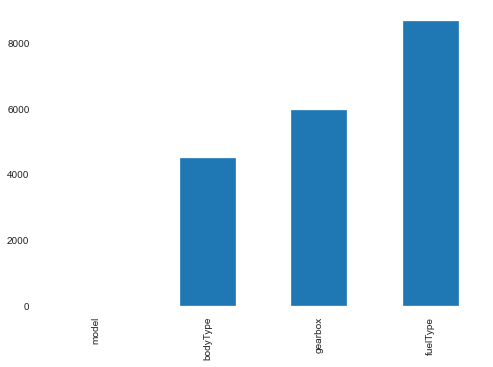

In [12]:
# nan可视化
missing = Train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

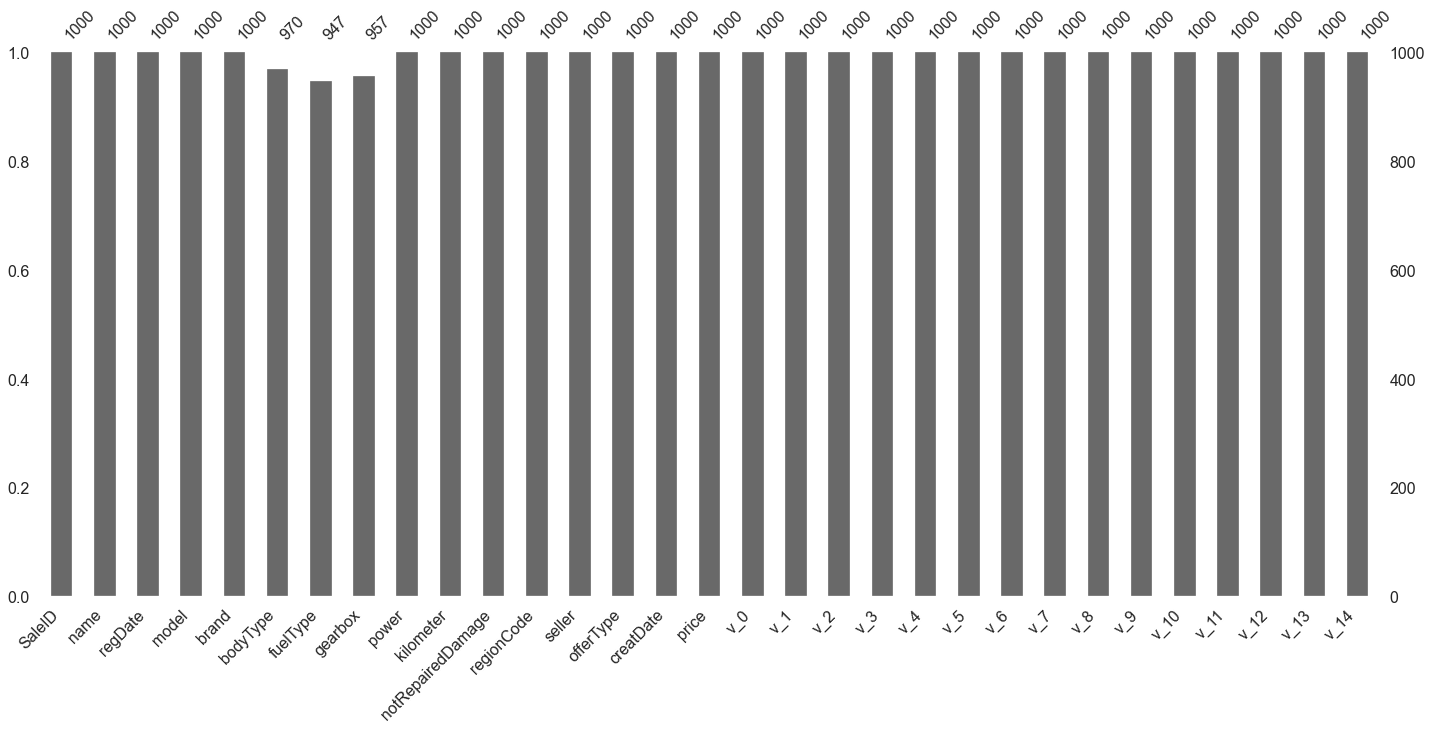

In [13]:
msno.bar(Train_data.sample(1000))

In [14]:
Test_data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   0
brand                   0
bodyType             1413
fuelType             2893
gearbox              1910
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

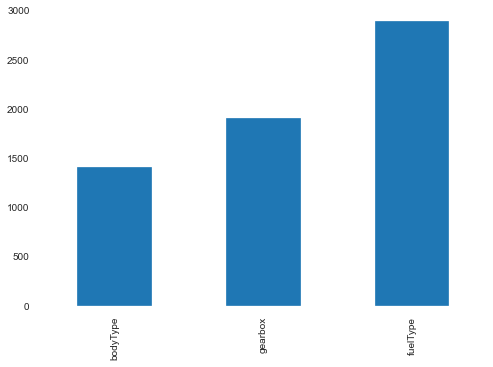

In [15]:
# nan可视化
missing = Test_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

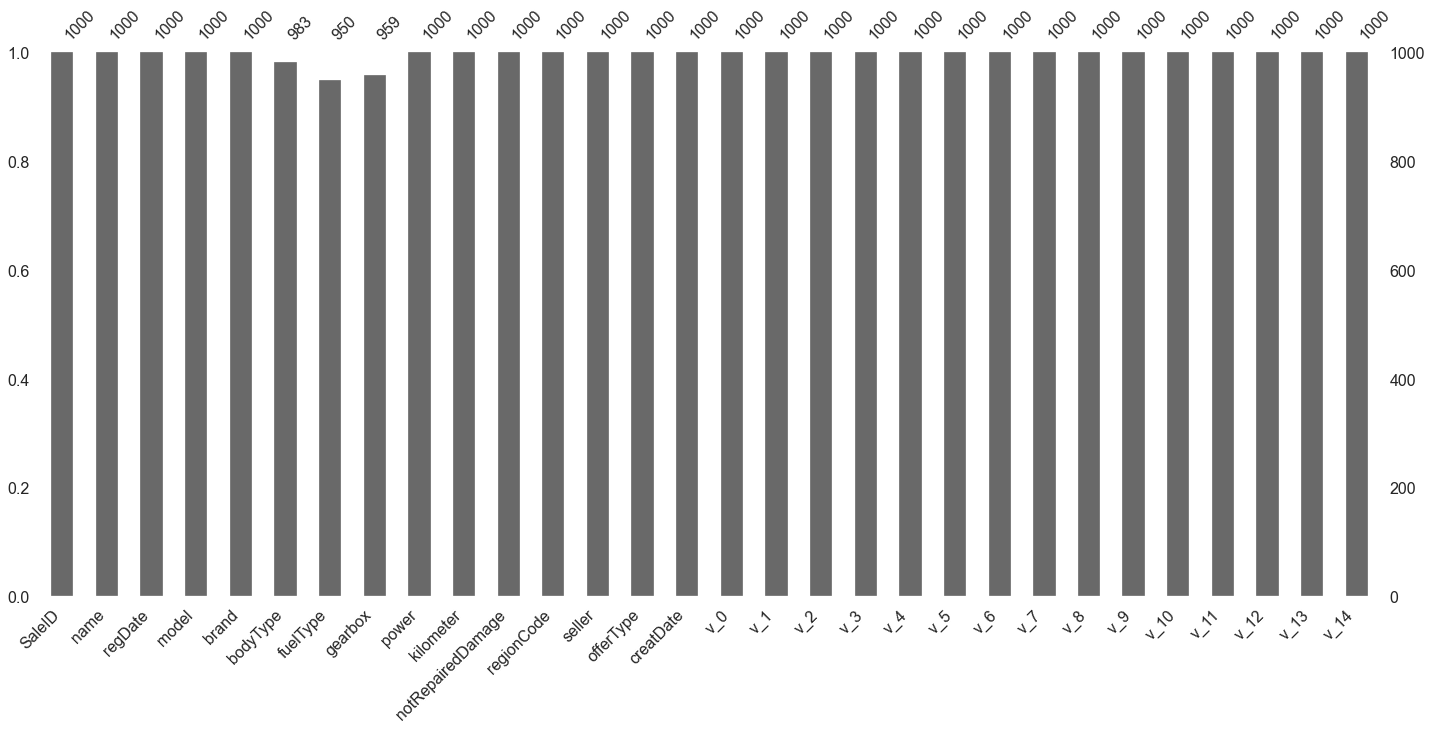

In [16]:
msno.bar(Test_data.sample(1000))

In [17]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [18]:
Test_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

#### 2.2 处理某些特殊特征

进行异常值替换or填充处理，对超级偏斜的特征进行删除

In [19]:
# 由于通过前面的.info()可知，只有'notRepairedDamage'为object，因此我们对其进行探索与处理
Train_data['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [20]:
Train_data['notRepairedDamage'].replace('-',np.nan, inplace=True)

In [21]:
Train_data['notRepairedDamage'].value_counts()

0.0    111361
1.0     14315
Name: notRepairedDamage, dtype: int64

In [22]:
Train_data["seller"].value_counts()

0    149999
1         1
Name: seller, dtype: int64

In [23]:
Train_data["offerType"].value_counts()

0    150000
Name: offerType, dtype: int64

In [24]:
del Train_data["seller"]
del Train_data["offerType"]
del Test_data["seller"]
del Test_data["offerType"]

In [25]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

#### 2.3 查看标签分布

In [26]:
Y_train=Train_data["price"]

In [27]:
Y_train.value_counts()

500      2337
1500     2158
1200     1922
1000     1850
2500     1821
         ... 
25321       1
8886        1
8801        1
37920       1
8188        1
Name: price, Length: 3763, dtype: int64

In [28]:
Y_train.describe()

count    150000.000000
mean       5923.327333
std        7501.998477
min          11.000000
25%        1300.000000
50%        3250.000000
75%        7700.000000
max       99999.000000
Name: price, dtype: float64

In [29]:
Y_train.skew()

3.3464867626369608

In [30]:
Y_train.kurt()

18.995183355632562

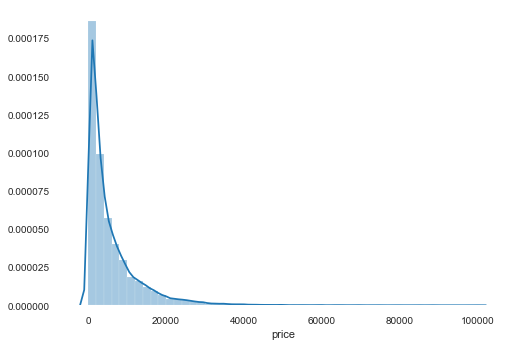

In [31]:
sns.distplot(Y_train)

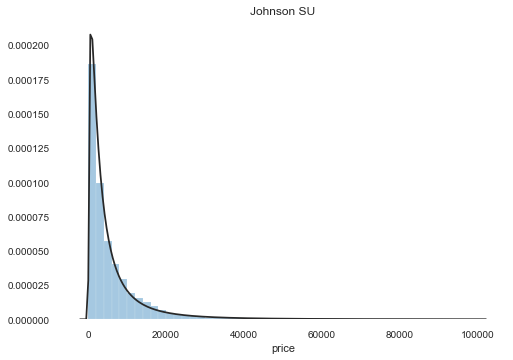

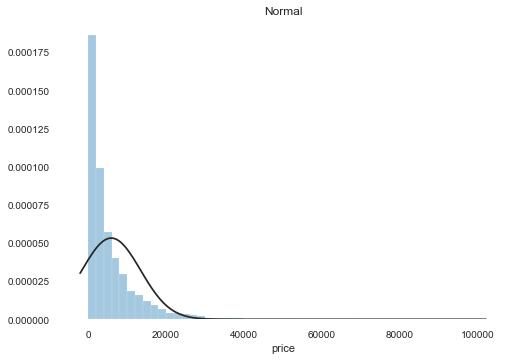

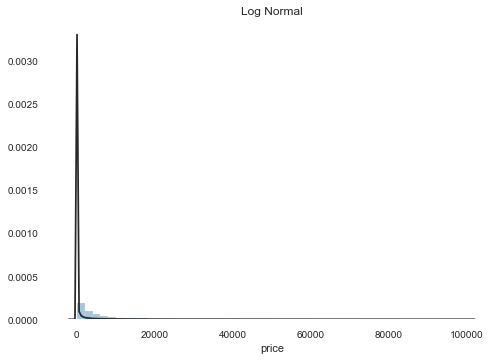

In [32]:
# 总体分布概况（无界约翰逊分布等）,看看通过哪种约翰逊变换可以将数据更好地拟合
# 可知第一种可以很好地拟合标签
import scipy.stats as st
y = Train_data['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
#distplot() 直方图，# 隐藏数据趋势kde，显示数据紧密度fit，kde=False, fit=stats.gamma

plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

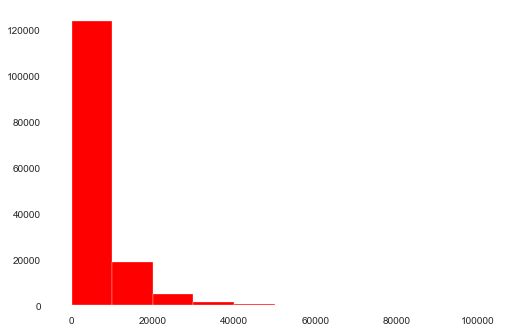

In [33]:
plt.hist(Train_data['price'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

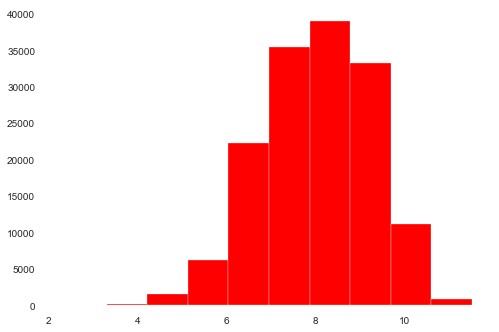

In [34]:
# log变换 z之后的分布较均匀，可以进行log变换进行预测，这也是预测问题常用的trick
plt.hist(np.log(Train_data['price']), orientation = 'vertical',histtype = 'bar', color ='red') 
plt.show()

#### 2.4 特征分析

In [35]:
# 顺便查看一下各个特征的偏度与峰度
Train_data.skew()

SaleID               6.017846e-17
name                 5.576058e-01
regDate              2.849508e-02
model                1.484388e+00
brand                1.150760e+00
bodyType             9.915299e-01
fuelType             1.595486e+00
gearbox              1.317514e+00
power                6.586318e+01
kilometer           -1.525921e+00
notRepairedDamage    2.430640e+00
regionCode           6.888812e-01
creatDate           -7.901331e+01
price                3.346487e+00
v_0                 -1.316712e+00
v_1                  3.594543e-01
v_2                  4.842556e+00
v_3                  1.062920e-01
v_4                  3.679890e-01
v_5                 -4.737094e+00
v_6                  3.680730e-01
v_7                  5.130233e+00
v_8                  2.046133e-01
v_9                  4.195007e-01
v_10                 2.522046e-02
v_11                 3.029146e+00
v_12                 3.653576e-01
v_13                 2.679152e-01
v_14                -1.186355e+00
dtype: float64

In [36]:
# 可以看到power 与creatDate的峰度特别大 ，and then？
Train_data.kurt()

SaleID                 -1.200000
name                   -1.039945
regDate                -0.697308
model                   1.740483
brand                   1.076201
bodyType                0.206937
fuelType                5.880049
gearbox                -0.264161
power                5733.451054
kilometer               1.141934
notRepairedDamage       3.908072
regionCode             -0.340832
creatDate            6881.080328
price                  18.995183
v_0                     3.993841
v_1                    -1.753017
v_2                    23.860591
v_3                    -0.418006
v_4                    -0.197295
v_5                    22.934081
v_6                    -1.742567
v_7                    25.845489
v_8                    -0.636225
v_9                    -0.321491
v_10                   -0.577935
v_11                   12.568731
v_12                    0.268937
v_13                   -0.438274
v_14                    2.393526
dtype: float64

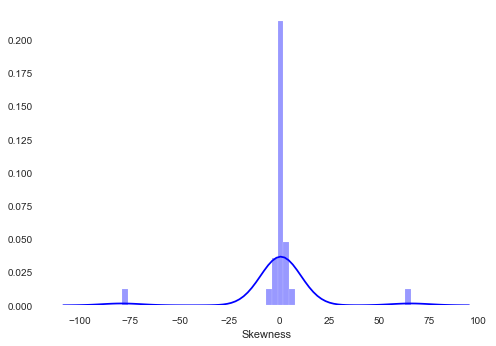

In [37]:
sns.distplot(Train_data.skew(),color='blue',axlabel ='Skewness')

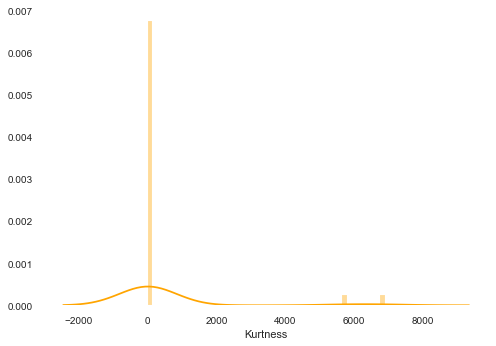

In [38]:
sns.distplot(Train_data.kurt(),color='orange',axlabel ='Kurtness')

####  特征分类，分为数字特征与类别特征

In [39]:
#分别数字特征与类别特征 
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' ]

categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode',]

In [40]:
# 类别特征nunique分布
for cat_fea in categorical_features:
    print(cat_fea + "的特征分布如下：")
    print("{}特征有{}个不同的值".format(cat_fea, Train_data[cat_fea].nunique()))
    print(Train_data[cat_fea].value_counts())

name的特征分布如下：
name特征有99662个不同的值
708       282
387       282
55        280
1541      263
203       233
         ... 
5074        1
7123        1
11221       1
13270       1
174485      1
Name: name, Length: 99662, dtype: int64
model的特征分布如下：
model特征有248个不同的值
0.0      11762
19.0      9573
4.0       8445
1.0       6038
29.0      5186
         ...  
245.0        2
209.0        2
240.0        2
242.0        2
247.0        1
Name: model, Length: 248, dtype: int64
brand的特征分布如下：
brand特征有40个不同的值
0     31480
4     16737
14    16089
10    14249
1     13794
6     10217
9      7306
5      4665
13     3817
11     2945
3      2461
7      2361
16     2223
8      2077
25     2064
27     2053
21     1547
15     1458
19     1388
20     1236
12     1109
22     1085
26      966
30      940
17      913
24      772
28      649
32      592
29      406
37      333
2       321
31      318
18      316
36      228
34      227
33      218
23      186
35      180
38       65
39        9
Name: brand, dtype: int64
body

In [41]:
# 可以看出'name'与'regionCode'过于稀疏，因此我们在类别特征中将其删除？那么呢？没用了？

#### 数字特征分析

In [42]:
numeric_features.append('price')

In [43]:
print(numeric_features)

['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'price']


In [44]:
#相关性分析 
price_numeric = Train_data[numeric_features]
correlation = price_numeric.corr()
print(correlation)
print(correlation['price'].sort_values(ascending = False),'\n')

              power  kilometer       v_0       v_1       v_2       v_3  \
power      1.000000  -0.019631  0.215028  0.023746 -0.031487 -0.185342   
kilometer -0.019631   1.000000 -0.225034 -0.022228 -0.110375  0.402502   
v_0        0.215028  -0.225034  1.000000  0.245049 -0.452591 -0.710480   
v_1        0.023746  -0.022228  0.245049  1.000000 -0.001133 -0.001915   
v_2       -0.031487  -0.110375 -0.452591 -0.001133  1.000000  0.001224   
v_3       -0.185342   0.402502 -0.710480 -0.001915  0.001224  1.000000   
v_4       -0.141013  -0.214861 -0.259714 -0.000468 -0.001021 -0.001694   
v_5        0.119727   0.049502  0.726250  0.109303 -0.921857 -0.233412   
v_6        0.025648  -0.024664  0.243783  0.999415  0.023877 -0.000747   
v_7       -0.060397  -0.017835 -0.584363 -0.110806  0.973689  0.191278   
v_8        0.155956  -0.407686  0.514149 -0.298966  0.180285 -0.933161   
v_9       -0.140203  -0.149422 -0.186243 -0.007698 -0.236164  0.079292   
v_10      -0.092717   0.083358 -0.5829

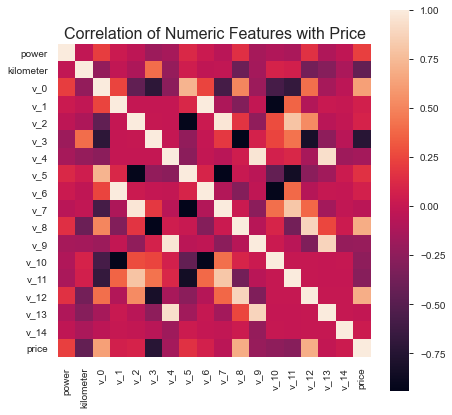

In [45]:
f , ax = plt.subplots(figsize = (7, 7))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)

sns.heatmap(correlation,square = True,vmax=1.0)#,annot=True

In [46]:
del price_numeric['price']
#因为前面price_numeric = Train_data[numeric_features]中的数字特征包含了price
# 因此分析完后，我们将price删除，则得到的是可以用于作为训练特征的特征

In [47]:
price_numeric

,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,60,12.5,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,0,15.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,163,12.5,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,193,15.0,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,68,5.0,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,163,15.0,45.316543,-3.139095,-1.269707,-0.736609,-1.505820,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,125,10.0,45.972058,-3.143764,-0.023523,-2.366699,0.698012,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,90,6.0,44.733481,-3.105721,0.595454,-2.279091,1.423661,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,156,15.0,45.658634,-3.204785,-0.441680,-1.179812,0.620680,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


In [48]:
# 将高度相关的几个特征删除其中某些，只留下一部分？
# del price_numeric['v_7']#删除过再次运行的话会发生key Error'v_7'，因为v_7已经被删除了

In [49]:
# del price_numeric['v_9']
# del price_numeric['v_1']

In [50]:
price_numeric

,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,60,12.5,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,0,15.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,163,12.5,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,193,15.0,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,68,5.0,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,163,15.0,45.316543,-3.139095,-1.269707,-0.736609,-1.505820,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,125,10.0,45.972058,-3.143764,-0.023523,-2.366699,0.698012,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,90,6.0,44.733481,-3.105721,0.595454,-2.279091,1.423661,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,156,15.0,45.658634,-3.204785,-0.441680,-1.179812,0.620680,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


In [51]:
numeric_features = ['power', 'kilometer', 'v_0', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6','v_8','v_10', 'v_11', 'v_12', 'v_13','v_14' ]

In [52]:
x_train=price_numeric

In [53]:
## 2) 查看几个特征的偏度和峰值
for col in numeric_features:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(Train_data[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(Train_data[col].kurt())  
         )#循环过程中自动换行？

power           Skewness: 65.86     Kurtosis: 5733.45
kilometer       Skewness: -1.53     Kurtosis: 001.14
v_0             Skewness: -1.32     Kurtosis: 003.99
v_2             Skewness: 04.84     Kurtosis: 023.86
v_3             Skewness: 00.11     Kurtosis: -00.42
v_4             Skewness: 00.37     Kurtosis: -00.20
v_5             Skewness: -4.74     Kurtosis: 022.93
v_6             Skewness: 00.37     Kurtosis: -01.74
v_8             Skewness: 00.20     Kurtosis: -00.64
v_10            Skewness: 00.03     Kurtosis: -00.58
v_11            Skewness: 03.03     Kurtosis: 012.57
v_12            Skewness: 00.37     Kurtosis: 000.27
v_13            Skewness: 00.27     Kurtosis: -00.44
v_14            Skewness: -1.19     Kurtosis: 002.39


#### 类别特征分析

In [54]:
for fea in categorical_features:
    print(fea)
    print(Train_data[fea].nunique())
#      print('{:15}'.format(col), 
#           'Skewness: {:05.2f}'.format(Train_data[col].skew()) , 
#           '   ' ,
#           'Kurtosis: {:06.2f}'.format(Train_data[col].kurt())  
#          )#循环过程中自动换行？

name
99662
model
248
brand
40
bodyType
8
fuelType
7
gearbox
2
notRepairedDamage
2
regionCode
7905


In [55]:
categorical_features

['name',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage',
 'regionCode']

In [56]:
# 因为 name和 regionCode的类别太稀疏了，这里我们把不稀疏的几类画一下
categorical_features = ['model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage']

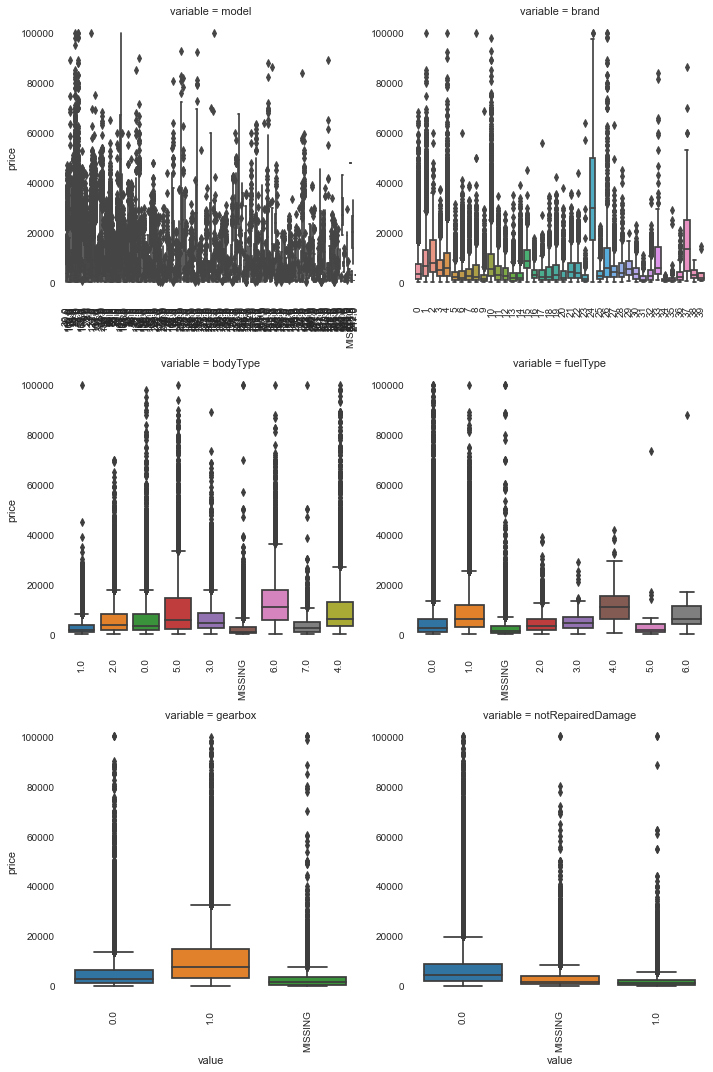

In [57]:
# 1) 类别特征箱形图可视化 异常值这么多不需要删除的吗？
for c in categorical_features:
    Train_data[c] = Train_data[c].astype('category')
    if Train_data[c].isnull().any():
        Train_data[c] = Train_data[c].cat.add_categories(['MISSING'])
        Train_data[c] = Train_data[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

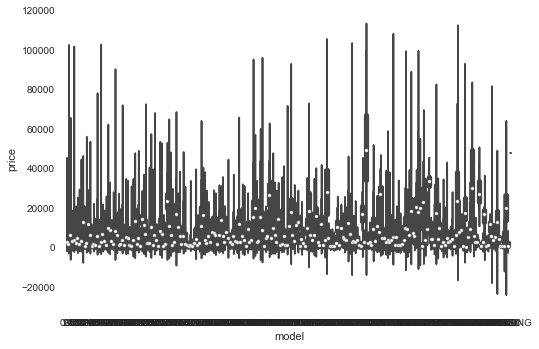

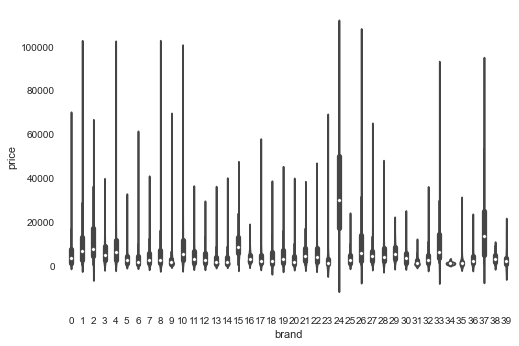

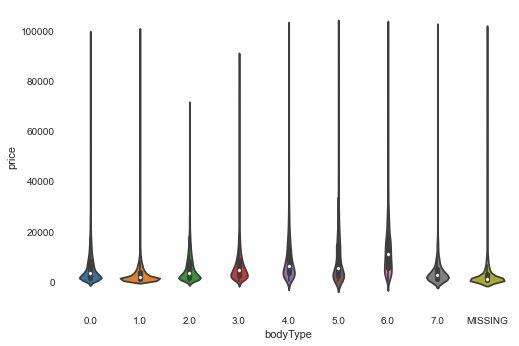

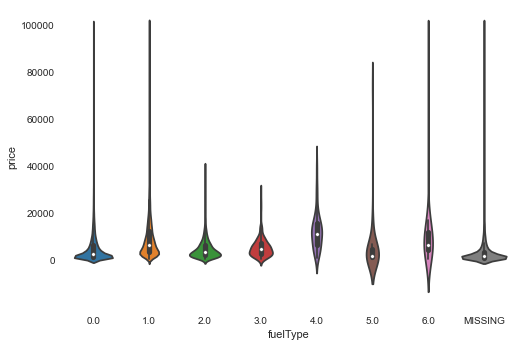

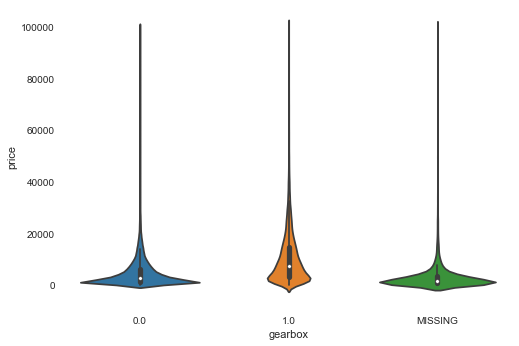

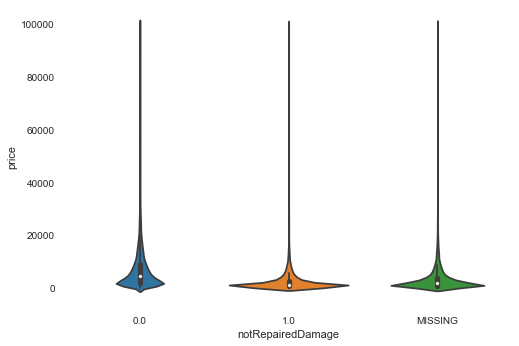

In [58]:
## 2) 类别特征的小提琴图可视化
catg_list = categorical_features
target = 'price'
for catg in catg_list :#利用循环来进行每个类别变量与price的小提琴图可视化
    sns.violinplot(x=catg, y=target, data=Train_data)
    plt.show()

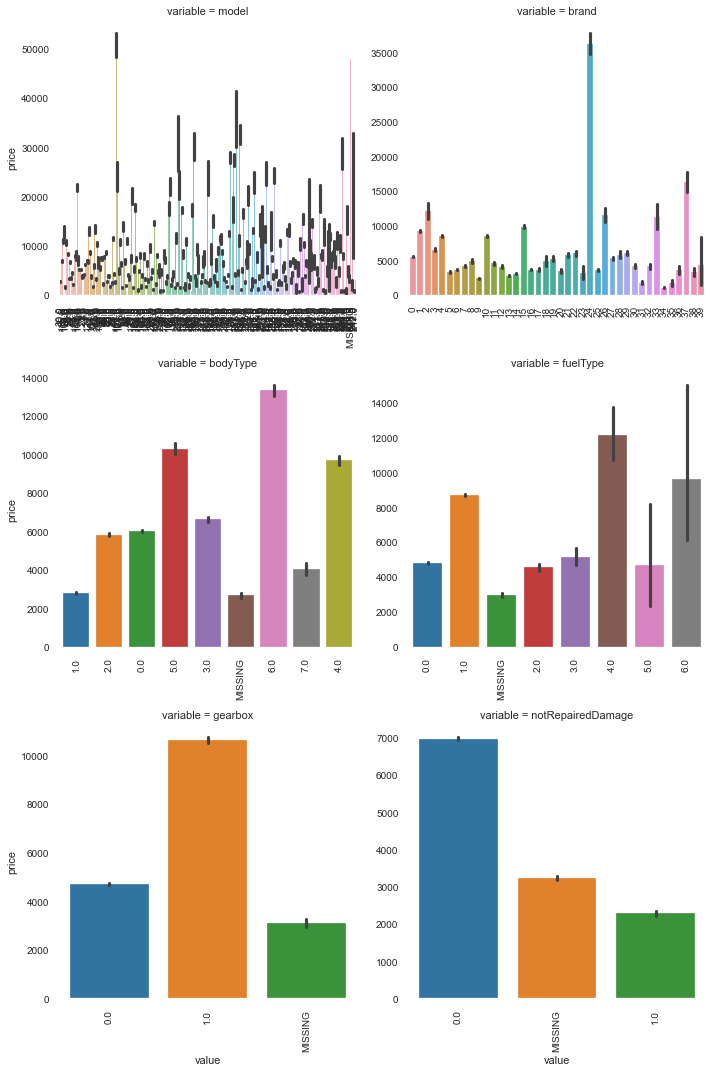

In [59]:
# 3) 类别特征的柱形图可视化
def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(bar_plot, "value", "price")

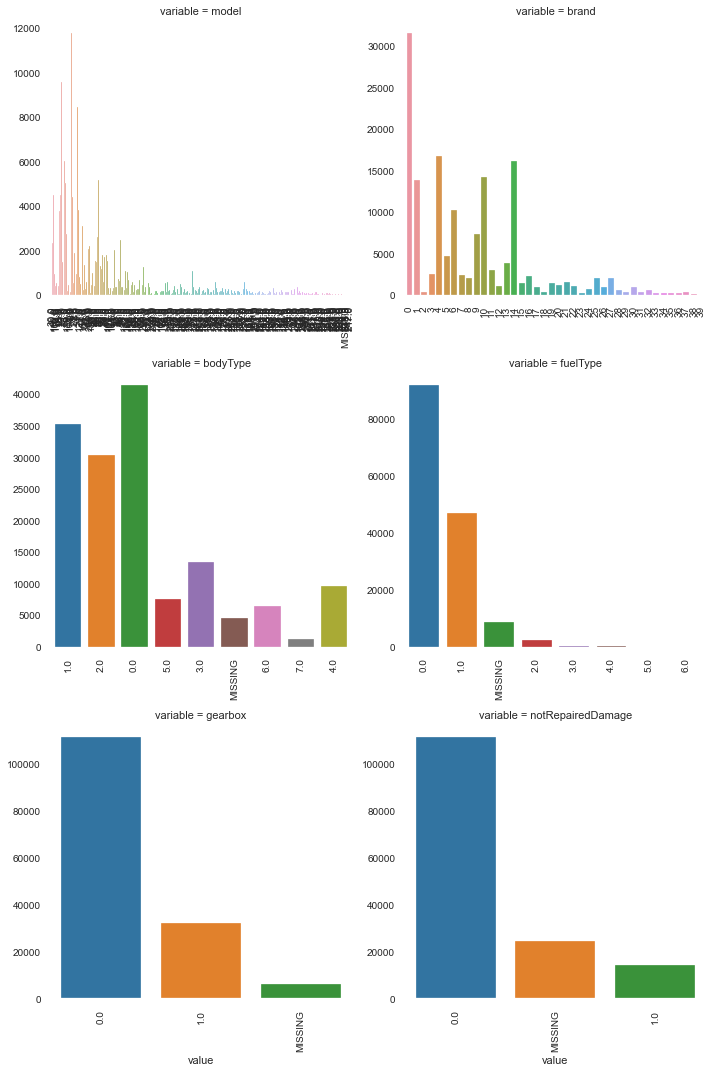

In [60]:
##  4) 类别特征的每个类别频数可视化(count_plot)
def count_plot(x,  **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data,  value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(count_plot, "value")

### 3 特征工程

#### 利用箱型图删除训练数据异常值

In [61]:
# def outliers_proc(data, col_name, scale=3):
#     """
#     用于清洗异常值，默认用 box_plot（scale=3）进行清洗
#     :param data: 接收 pandas 数据格式
#     :param col_name: pandas 列名 (一列一列进行操作)
#     :param scale: 尺度
#     :return:
#     """

#     def box_plot_outliers(data_ser, box_scale):
#         """
#         利用箱线图去除异常值
#         :param data_ser: 接收 pandas.Series 数据格式
#         :param box_scale: 箱线图尺度，
#         :return:
#         """
#         iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
#         val_low = data_ser.quantile(0.25) - iqr
#         val_up = data_ser.quantile(0.75) + iqr
#         rule_low = (data_ser < val_low)
#         rule_up = (data_ser > val_up)
#         return (rule_low, rule_up), (val_low, val_up)

#     data_n = data.copy()
#     data_series = data_n[col_name]
#     rule, value = box_plot_outliers(data_series, box_scale=scale)
#     index = np.arange(data_series.shape[0])[rule[0] | rule[1]]#shape[0]是列
#     print("Delete number is: {}".format(len(index)))
#     data_n = data_n.drop(index)
#     data_n.reset_index(drop=True, inplace=True)
#     print("Now column number is: {}".format(data_n.shape[0]))
#     index_low = np.arange(data_series.shape[0])[rule[0]]
#     outliers = data_series.iloc[index_low]
#     print("Description of data less than the lower bound is:")
#     print(pd.Series(outliers).describe())
#     index_up = np.arange(data_series.shape[0])[rule[1]]
#     outliers = data_series.iloc[index_up]
#     print("Description of data larger than the upper bound is:")
#     print(pd.Series(outliers).describe())
    
#     fig, ax = plt.subplots(1, 2, figsize=(10, 7))
#     sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
#     sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
#     return data_n

In [62]:
"""这里包装了一个异常值处理的代码，可以随便调用"""
def outliers_proc(data, col_name, scale=3):
    """
        用于截尾异常值， 默认用box_plot(scale=3)进行清洗
        param:
            data：接收pandas数据格式
            col_name: pandas列名
            scale: 尺度
    """
    data_col = data[col_name]
    Q1 = data_col.quantile(0.25) # 0.25分位数
    Q3 = data_col.quantile(0.75)  # 0,75分位数
    IQR = Q3 - Q1

    data_col[data_col < Q1 - (scale * IQR)] = Q1 - (scale * IQR)
    data_col[data_col > Q3 + (scale * IQR)] = Q3 + (scale * IQR)

    return data[col_name]

In [63]:
Train_data['power'] = outliers_proc(Train_data, 'power')

In [97]:
Train_data.shape

(150000, 29)

In [64]:
# Train_data = outliers_proc(Train_data, 'power', scale=3)


#### 3.1 特征构造

In [65]:
# 训练集和测试集放在一起，方便构造特征
# Train_data['train']=1#每个数据集都添加一列'train'？
# Test_data['train']=0
data = pd.concat([Train_data, Test_data], ignore_index=True)

#### 时间特征构造

In [66]:
# 这里是为了标记一下哪些字段有错误
def regDateFalse(x):
    if str(x)[4:6] == '00':
        return 1
    else: 
        return 0
data['regDateFalse'] = data['regDate'].apply(lambda x: regDateFalse(x))#'regDate'总共8位，eg：20040402
# 这里是改正错误字段
def changeFalse(x):
    x = str(x)
    if x[4:6] == '00':
        x = x[0:4] + '01' + x[6:]
        x = int(x)
    return x
data['regDate'] = data['regDate'].apply(lambda x: changeFalse(x))

In [67]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
#数据里有时间出错的格式，所以我们需要 errors='coerce'

data.loc[data.regDateFalse==1, 'used_time'] += 30

del data['regDateFalse']

In [68]:
# 使用时间换成年来表示
data['used_time'] = data['used_time'] / 365.0
print(data['used_time'].isnull().sum())# 利用这种方法构造得特征uesd_time没有缺失值

# data['Is_scrap'] = data['used_time'].apply(lambda x: 1 if x>=10 else 0)

0


In [69]:
#  汽车的使用时间3年，3-7年，10年以上的估价会有不同，所以分一下箱
bins = [0, 3, 7, 10, 20, 30]
data['estivalue'] = pd.cut(data['used_time'], bins, labels=False)


In [ ]:
data[['estivalue', 'used_time']].head()

In [ ]:
# 选出淡旺季，每年的2， 3月份及6,7,8月份是整个汽车行业的低谷
# 年初和年末及9月份是二手车销售的黄金时期， 所以根据上线时间选出淡旺季。

low_seasons = ['3', '6', '7', '8']
data['is_low_seasons'] = data['creatDate'].apply(lambda x: 1 if str(x)[5] in low_seasons else 0)

In [70]:
# 构造汽车使用时间统计特征的话需要在训练集上先计算
train_data_timestats = Train_data.copy()   # 不要动train_data

train_data_timestats['estivalue'] = data['estivalue'][:Train_data.shape[0]]
train_data_timestats['price'] = Train_data['price']

train_gt = train_data_timestats.groupby('estivalue')
all_info = {}
for kind, kind_data in train_gt:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['estivalue_count'] = len(kind_data)
    info['estivalue_price_max'] = kind_data.price.max()
    info['estivalue_price_median'] = kind_data.price.median()
    info['estivalue_price_min'] = kind_data.price.min()
    info['estivalue_price_sum'] = kind_data.price.sum()
    info['estivalueprice_std'] = kind_data.price.std()
    info['estivalue_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info

estivalue_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "estivalue"})
time_data = data.merge(estivalue_fe, how='left', on='estivalue')

In [71]:
data = data.drop(['creatDate', 'regDate'], axis=1)

#### 类别特征构造

In [72]:
# 从邮编中提取城市信息，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
#list[:-3]取不到最后三个，也就是从前1个number当中提取城市信息？总共四位

In [73]:
# 私用车和商务车分开(bodyType)
com_car = [2.0, 3.0, 6.0]  # 商用车
GL_car = [0.0, 4.0, 5.0]   # 豪华系列  
self_car = [1.0, 7.0]

def class_bodyType(x):
    if x in GL_car:
        return 0
    elif x in com_car:
        return 1
    else:
        return 2

data['car_class'] = data['bodyType'].apply(lambda x : class_bodyType(x))

In [74]:
# 新能源车和燃油车分开(fuelType)
# 是否是新能源
is_fuel = [0.0, 1.0, 2.0, 3.0]
data['is_fuel'] = data['fuelType'].apply(lambda x: 1 if x in is_fuel else 0)

In [75]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("brand")
#Train_data中以brand列为标准进行分组，其余为number的列直接进行统计？
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')
#pandas.merge根据一个或多个键进行连接，’left‘方法表示对所有左表的键进行联合，outer表示对两张表的并集进行联合

In [76]:
data = data.drop(['bodyType', 'fuelType','regionCode'], axis=1)
# del cat_data['bodyType']
# del cat_data['fuelType']

#### 数字特征构造

In [77]:
# 对里程进行一个分箱操作,分成三段
bins = [0, 5, 10, 15]
data['kil_bin'] = pd.cut(data['kilometer'], bins, labels=False)

In [78]:
# V系列特征的统计特征,平均值， 总和和标准差
v_features = ['v_' + str(i) for i in range(15)]
data['v_sum'] =data[v_features].apply(lambda x: x.sum(), axis=1)
data['v_mean'] = data[v_features].apply(lambda x: x.mean(), axis=1)
data['v_std'] = data[v_features].apply(lambda x: x.std(), axis=1)

In [79]:
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [80]:
# 利用好了，就可以删除不需要的数据
# data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [81]:
# data = data.drop(['v_1','v_7', 'v_9'], axis=1)#根据之前地数字特征相关性可知，有些特征高度相关，因此我们删除部分匿名特征

In [100]:
data.shape

(200000, 41)

In [101]:
data.columns

Index(['SaleID', 'brand', 'gearbox', 'kilometer', 'model', 'name',
       'notRepairedDamage', 'power', 'price', 'v_0', 'v_1', 'v_10', 'v_11',
       'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'used_time', 'estivalue', 'city', 'car_class', 'is_fuel',
       'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'kil_bin', 'v_sum', 'v_mean', 'v_std',
       'power_bin'],
      dtype='object')

In [99]:
data.head()

,SaleID,brand,gearbox,kilometer,model,name,notRepairedDamage,power,price,v_0,...,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,kil_bin,v_sum,v_mean,v_std,power_bin
0,0,6,0,12.5,30,736,0.0,60,1850.0,43.357796,...,1800.0,13.0,36902172.0,4681.293524,3611.49,2,50.476946,3.365130,11.197367,5.0
1,1,1,0,15.0,40,2262,MISSING,0,3600.0,45.305273,...,6499.0,15.0,127916065.0,9369.631497,9272.64,2,45.894715,3.059648,11.880699,NaN
2,2,15,0,12.5,115,14874,0.0,163,6222.0,45.978359,...,8500.0,100.0,14373814.0,5425.058140,9851.83,2,48.206504,3.213767,12.000400,16.0
3,3,10,1,15.0,109,71865,0.0,193,2400.0,45.687478,...,5400.0,15.0,120700489.0,8988.307535,8470.21,2,42.682330,2.845489,12.012923,19.0
4,4,5,0,5.0,110,111080,0.0,68,5200.0,44.383511,...,2300.0,20.0,15424120.0,3343.624586,3305.64,0,52.959089,3.530606,11.376666,6.0


In [102]:
# 目前的数据其实已经可以给树模型使用了，所以我们导出一下 树模型具有归一化功能所以不需对数据进行预处理？
data.to_csv('mydata_for_tree.csv', index=0)


### 4、模型调参

#### 对数据进行内存减小，以及缺失值处理和类型转换

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [104]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [142]:
d=reduce_mem_usage(pd.read_csv('mydata_for_tree.csv'))

Memory usage of dataframe is 65600128.00 MB
Memory usage after optimization is: 17024896.00 MB
Decreased by 74.0%


In [143]:
d.shape

(200000, 41)

In [144]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 41 columns):
SaleID                 200000 non-null int32
brand                  200000 non-null int8
gearbox                198090 non-null category
kilometer              200000 non-null float16
model                  200000 non-null category
name                   200000 non-null int32
notRepairedDamage      200000 non-null category
power                  200000 non-null int16
price                  150000 non-null float32
v_0                    200000 non-null float16
v_1                    200000 non-null float16
v_10                   200000 non-null float16
v_11                   200000 non-null float16
v_12                   200000 non-null float16
v_13                   200000 non-null float16
v_14                   200000 non-null float16
v_2                    200000 non-null float16
v_3                    200000 non-null float16
v_4                    200000 non-null float16
v_

In [145]:
# """这里包装了一个异常值处理的代码，可以随便调用"""
# def outliers_proc(data, col_name, scale=3):
#     """
#         用于截尾异常值， 默认用box_plot(scale=3)进行清洗
#         param:
#             data：接收pandas数据格式
#             col_name: pandas列名
#             scale: 尺度
#     """
#     data_col = data[col_name]
#     Q1 = data_col.quantile(0.25) # 0.25分位数
#     Q3 = data_col.quantile(0.75)  # 0,75分位数
#     IQR = Q3 - Q1

#     data_col[data_col < Q1 - (scale * IQR)] = Q1 - (scale * IQR)
#     data_col[data_col > Q3 + (scale * IQR)] = Q3 + (scale * IQR)

#     return data[col_name]

In [146]:
# 不能掩耳盗铃，更改测试集的数据
# d['power'] = outliers_proc(d, 'power')

In [147]:
d_y=d['price']

In [148]:
d_y.value_counts()

500.0      2337
1500.0     2158
1200.0     1922
1000.0     1850
2500.0     1821
           ... 
10280.0       1
18940.0       1
647.0         1
57850.0       1
32.0          1
Name: price, Length: 3763, dtype: int64

In [149]:
# 切分训练集与测试集
train=d.iloc[:150000]
test=d.iloc[150000:]

In [150]:
print(train.shape)
train.info()

(150000, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 41 columns):
SaleID                 150000 non-null int32
brand                  150000 non-null int8
gearbox                150000 non-null category
kilometer              150000 non-null float16
model                  150000 non-null category
name                   150000 non-null int32
notRepairedDamage      150000 non-null category
power                  150000 non-null int16
price                  150000 non-null float32
v_0                    150000 non-null float16
v_1                    150000 non-null float16
v_10                   150000 non-null float16
v_11                   150000 non-null float16
v_12                   150000 non-null float16
v_13                   150000 non-null float16
v_14                   150000 non-null float16
v_2                    150000 non-null float16
v_3                    150000 non-null float16
v_4                    150000 non-nu

In [151]:
print(test.shape)
test.info()

(50000, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 150000 to 199999
Data columns (total 41 columns):
SaleID                 50000 non-null int32
brand                  50000 non-null int8
gearbox                48090 non-null category
kilometer              50000 non-null float16
model                  50000 non-null category
name                   50000 non-null int32
notRepairedDamage      50000 non-null category
power                  50000 non-null int16
price                  0 non-null float32
v_0                    50000 non-null float16
v_1                    50000 non-null float16
v_10                   50000 non-null float16
v_11                   50000 non-null float16
v_12                   50000 non-null float16
v_13                   50000 non-null float16
v_14                   50000 non-null float16
v_2                    50000 non-null float16
v_3                    50000 non-null float16
v_4                    50000 non-null float16
v_5      

In [152]:
na=train.isnull().sum()
na

SaleID                     0
brand                      0
gearbox                    0
kilometer                  0
model                      0
name                       0
notRepairedDamage          0
power                      0
price                      0
v_0                        0
v_1                        0
v_10                       0
v_11                       0
v_12                       0
v_13                       0
v_14                       0
v_2                        0
v_3                        0
v_4                        0
v_5                        0
v_6                        0
v_7                        0
v_8                        0
v_9                        0
used_time                  0
estivalue                  0
city                   36680
car_class                  0
is_fuel                    0
brand_amount               0
brand_price_max            0
brand_price_median         0
brand_price_min            0
brand_price_sum            0
brand_price_st

In [153]:
print(na[na> 0])

city         36680
power_bin    15734
dtype: int64


In [154]:
train['notRepairedDamage'].value_counts()

0.0        111361
MISSING     24324
1.0         14315
-               0
Name: notRepairedDamage, dtype: int64

In [180]:
train['gearbox'].value_counts()

0.0    117604
1.0     32396
Name: gearbox, dtype: int64

In [155]:
train['city'].value_counts()

1.0    31886
2.0    26481
3.0    20545
4.0    14969
5.0    10047
6.0     6304
7.0     2986
8.0      102
Name: city, dtype: int64

In [156]:
train['power_bin'].value_counts()

10.0    18080
7.0     13186
13.0    12079
5.0     11456
14.0    10611
11.0     9768
8.0      8952
16.0     8153
12.0     6877
6.0      5500
17.0     4058
19.0     3472
4.0      3360
9.0      3146
23.0     2399
18.0     2371
15.0     2140
21.0     2010
20.0     1472
22.0     1365
24.0     1037
27.0      783
25.0      438
28.0      430
26.0      392
29.0      377
3.0       217
0.0        80
1.0        40
2.0        17
Name: power_bin, dtype: int64

In [157]:
na=test.isnull().sum()
na

SaleID                     0
brand                      0
gearbox                    0
kilometer                  0
model                      0
name                       0
notRepairedDamage          0
power                      0
price                      0
v_0                        0
v_1                        0
v_10                       0
v_11                       0
v_12                       0
v_13                       0
v_14                       0
v_2                        0
v_3                        0
v_4                        0
v_5                        0
v_6                        0
v_7                        0
v_8                        0
v_9                        0
used_time                  0
estivalue                  0
city                   36680
car_class                  0
is_fuel                    0
brand_amount               0
brand_price_max            0
brand_price_median         0
brand_price_min            0
brand_price_sum            0
brand_price_st

In [158]:
print(na[na> 0])

city         36680
power_bin    15734
dtype: int64


In [161]:
# from sklearn.impute import SimpleImputer

# my_imputer= SimpleImputer(strategy="most_frequent")
# #default: missing_values=np.nan, strategy='mean'   处理稀疏矩阵：missing_values=-1  其他策略：strategy="most_frequent"
# train= my_imputer.fit_transform(train)


In [162]:
# train= train.replace('MISSING',0).reset_index(drop=True)


In [163]:
# def split_train(data,test_ratio):
# #     np.random.seed(43)
#     shuffled_indices=np.random.permutation(len(data))
#     test_set_size=int(len(data)*test_ratio)
#     test_indices =shuffled_indices[:test_set_size]
#     train_indices=shuffled_indices[test_set_size:]
#     return data.iloc[train_indices],data.iloc[test_indices]

In [164]:
# train,test=split_train(d,0.25)
# train=d.iloc[:150000]
# test=d.iloc[150000:]

In [165]:
# train_X,val_X,train_y_ln,val_y_ln = train_test_split(train_X1,train_y_ln1,test_size=0.3)

In [185]:
# 对数据集中的类别特征'notRepairedDamage'与'gearbox'进行类型转换
# train = train.fillna(0).replace('MISSING', 0).reset_index(drop=True)
train['notRepairedDamage']=train['notRepairedDamage'].replace('MISSING',0.0)
# train['notRepairedDamage']=train['notRepairedDamage'].replace('-',0)
train['notRepairedDamage'] = train['notRepairedDamage'].astype(np.float32)
train['gearbox']=train['gearbox'].replace('MISSING',0.0)
train['gearbox'] = train['gearbox'].astype(np.float32)

test['notRepairedDamage']=test['notRepairedDamage'].replace('-',0.0)
test['notRepairedDamage'] = test['notRepairedDamage'].astype(np.float32)
test['gearbox']=test['gearbox'].replace('MISSING',0.0)
test['gearbox'] = test['gearbox'].astype(np.float32)

In [197]:
test['gearbox'].value_counts()

0.0    37301
1.0    10789
Name: gearbox, dtype: int64

In [199]:
train['notRepairedDamage'].dtype

dtype('float32')

In [175]:
train['notRepairedDamage'].value_counts()

0.0    135685
1.0     14315
Name: notRepairedDamage, dtype: int64

In [191]:
continuous_feature_names = [x for x in d.columns if x not in ['price','SaleID','model']]

train_X1 = train[continuous_feature_names]
train_y_ln1 = np.log(train['price'] + 1)
train_X,val_X,train_y_ln,val_y_ln = train_test_split(train_X1,train_y_ln1,test_size=0.3)
# import datetime

# train= train.reset_index(drop=True)

# split_point = len(train) / 5 * 4

# train = train.loc[:split_point].dropna()
# val = train.loc[split_point:].dropna()

# train_X = train[continuous_feature_names]
# train_y_ln = np.log(train['price'] + 1)
# val_X = val[continuous_feature_names]
# val_y_ln = np.log(val['price'] + 1)

test_X=test[continuous_feature_names]

In [192]:
# data.fillna({0:1000, 1:100, 2:0, 4:5}) 
#对数据集中的含有nan值得特征city与power_bin进行缺失值填充

train_X.fillna({'city':1.0, 'power_bin':10.0},inplace=True)
val_X.fillna({'city':1.0, 'power_bin':10.0},inplace=True)
test_X.fillna({'city':1.0, 'power_bin':10.0},inplace=True)
train_X1.fillna({'city':1.0, 'power_bin':10.0},inplace=True)

train_y_ln.fillna(train_y_ln.mean(),inplace=True)
val_y_ln.fillna(val_y_ln.mean(),inplace=True)
train_y_ln1.fillna(val_y_ln.mean(),inplace=True)

In [193]:
print(train_X.isnull().sum())
print(val_X.isnull().sum())
print(test_X.isnull().sum())
print(train_y_ln.isnull().sum())
print(val_y_ln.isnull().sum())
print(train_X1.isnull().sum())
print(train_y_ln1.isnull().sum())

brand                  0
gearbox                0
kilometer              0
name                   0
notRepairedDamage      0
power                  0
v_0                    0
v_1                    0
v_10                   0
v_11                   0
v_12                   0
v_13                   0
v_14                   0
v_2                    0
v_3                    0
v_4                    0
v_5                    0
v_6                    0
v_7                    0
v_8                    0
v_9                    0
used_time              0
estivalue              0
city                   0
car_class              0
is_fuel                0
brand_amount           0
brand_price_max        0
brand_price_median     0
brand_price_min        0
brand_price_sum        0
brand_price_std        0
brand_price_average    0
kil_bin                0
v_sum                  0
v_mean                 0
v_std                  0
power_bin              0
dtype: int64
brand                  0
gearbox     

In [194]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105000 entries, 49147 to 33692
Data columns (total 38 columns):
brand                  105000 non-null int64
gearbox                105000 non-null float32
kilometer              105000 non-null float64
name                   105000 non-null int64
notRepairedDamage      105000 non-null float32
power                  105000 non-null int64
v_0                    105000 non-null float64
v_1                    105000 non-null float64
v_10                   105000 non-null float64
v_11                   105000 non-null float64
v_12                   105000 non-null float64
v_13                   105000 non-null float64
v_14                   105000 non-null float64
v_2                    105000 non-null float64
v_3                    105000 non-null float64
v_4                    105000 non-null float64
v_5                    105000 non-null float64
v_6                    105000 non-null float64
v_7                    105000 non-null float64

In [195]:
val_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 19902 to 114636
Data columns (total 38 columns):
brand                  45000 non-null int64
gearbox                45000 non-null float32
kilometer              45000 non-null float64
name                   45000 non-null int64
notRepairedDamage      45000 non-null float32
power                  45000 non-null int64
v_0                    45000 non-null float64
v_1                    45000 non-null float64
v_10                   45000 non-null float64
v_11                   45000 non-null float64
v_12                   45000 non-null float64
v_13                   45000 non-null float64
v_14                   45000 non-null float64
v_2                    45000 non-null float64
v_3                    45000 non-null float64
v_4                    45000 non-null float64
v_5                    45000 non-null float64
v_6                    45000 non-null float64
v_7                    45000 non-null float64
v_8               

In [196]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 150000 to 199999
Data columns (total 38 columns):
brand                  50000 non-null int8
gearbox                48090 non-null float32
kilometer              50000 non-null float16
name                   50000 non-null int32
notRepairedDamage      50000 non-null float32
power                  50000 non-null int16
v_0                    50000 non-null float16
v_1                    50000 non-null float16
v_10                   50000 non-null float16
v_11                   50000 non-null float16
v_12                   50000 non-null float16
v_13                   50000 non-null float16
v_14                   50000 non-null float16
v_2                    50000 non-null float16
v_3                    50000 non-null float16
v_4                    50000 non-null float16
v_5                    50000 non-null float16
v_6                    50000 non-null float16
v_7                    50000 non-null float16
v_8               

In [214]:
# model=LGBMRegressor(n_estimators = 100)
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)#模型lgb先不设定学习率，然后直接通过GridSearchCV网格搜索来决定模型最优学习率
    gbm.fit(x_train, y_train)
    return gbm

# num_leaves - 控制了叶节点的数目，它是控制树模型复杂度的主要参数,取值应 <= 2 ^（max_depth）
# n_estimators - 分多少颗决策树(总共迭代的次数)
# max_depth - 控制了树的最大深度,该参数可以显式的限制树的深度

In [201]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))#最小值
    print('_max:',np.max(data))#最大值
    print('_mean',np.mean(data))#平均值
    print('_ptp',np.ptp(data))#最大最小值之差，也就是极差
    print('_std',np.std(data))#标准差
    print('_var',np.var(data))#方差

In [215]:
print('Train lgb...')
model_lgb = build_model_lgb(train_X,train_y_ln)
val_lgb = model_lgb.predict(val_X)
MAE_lgb = mean_absolute_error(val_y_ln,val_lgb)#从sklearn.metrics中import出来了MAE以及MSE
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')

model_lgb_pre = build_model_lgb(train_X1,train_y_ln1)
subA_lgb = model_lgb.predict(test_X)
print('Sta of Predict lgb:')

Sta_inf(subA_lgb)

Train lgb...
MAE of val with lgb: 0.1277806976788632
Predict lgb...
Sta of Predict lgb:
_min 2.8005908048754304
_max: 11.374432651569556
_mean 8.034275592726804
_ptp 8.573841846694126
_std 1.1994672823331642
_var 1.4387217613877066


In [227]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model
# 
# def build_model_xgb(x_train,y_train):
#     model = xgb.XGBRegressor(n_estimators=150,gamma=0, subsample=0.8,\
#         colsample_bytree=0.9, max_depth=5)
#     param_grid = {
#         'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     }
#     model = GridSearchCV(model, param_grid)#模型xgb先不设定学习率，然后直接通过GridSearchCV网格搜索来决定模型最优学习率
#     model.fit(x_train, y_train)
#     return model


In [228]:
print('Train xgb...')
model_xgb = build_model_xgb(train_X,train_y_ln)
val_xgb = model_xgb.predict(val_X)
MAE_xgb = mean_absolute_error(val_y_ln,val_lgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(train_X1,train_y_ln1)
subA_xgb = model_xgb_pre.predict(test_X)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
[00:21:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of val with xgb: 0.1277806976788632
Predict xgb...
[00:23:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Sta of Predict xgb:
_min 2.72762
_max: 11.475458
_mean 8.0344
_ptp 8.747838
_std 1.1983227
_var 1.4359772


In [229]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
# val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(val_y_ln,val_Weighted))

MAE of val with Weighted ensemble: 0.12515992725083164


In [230]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

_min 2.8125126618447585
_max: 11.406592412973499
_mean 8.03433722652154
_ptp 8.59407975112874
_std 1.1983225148961536
_var 1.4359768497070422


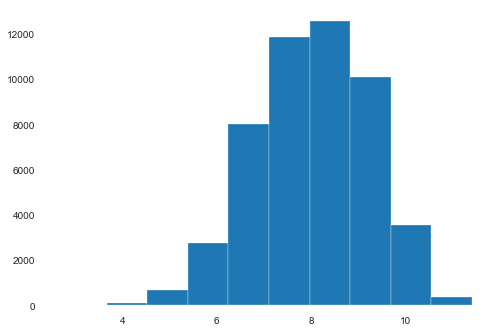

In [231]:
# 查看预测值的统计进行
Sta_inf(sub_Weighted)
plt.hist(sub_Weighted)

plt.show()
plt.close()

_min 2.4849066497880004
_max: 11.512925464970229
_mean 8.035270518212288
_ptp 9.028018815182229
_std 1.2182183819249919
_var 1.4840560260599451


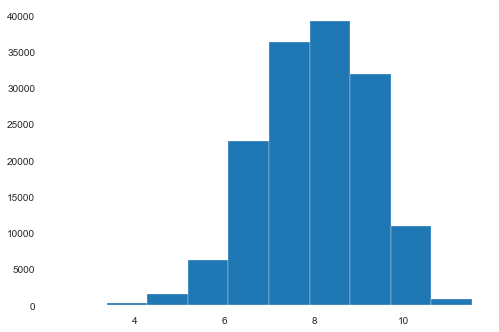

In [232]:
Sta_inf(train_y_ln1)
plt.hist(train_y_ln1)

plt.show()
plt.close()

In [233]:
sub_Weighted=np.exp(sub_Weighted)
sub_Weighted[sub_Weighted<10]=10 

In [234]:
len(Test_data.SaleID)

50000

In [235]:
sub = pd.DataFrame()
sub['SaleID'] = Test_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighte4.9.3.csv',index=False)

In [236]:
sub.head()


,SaleID,price
0,150000,35867.779593
1,150001,345.689247
2,150002,5747.902335
3,150003,12015.481612
4,150004,654.351100
